Notebook to read simulations about (H,d,compression) parameters

In [87]:
using Revise, Statistics
using AttentionBasedPlmDCA, PlmDCA
using PyPlot, LaTeXStrings
using JLD2

In [18]:
fastafile = "../../ArDCAData/data/PF00014/PF00014_mgap6.fasta.gz"
structfile = "../../ArDCAData/data/PF00014/PF00014_struct.dat"

"../../ArDCAData/data/PF00014/PF00014_struct.dat"

In [107]:
PPVplm = compute_PPV(plmdca(fastafile, verbose = false).score,structfile);

removing duplicate sequences... done: 13600 -> 8871
θ = 0.33088461264010915 threshold = 17.0
M = 8871 N = 53 Meff = 2950.925530761646
preprocessing took 1.273608875 seconds


In [200]:
@load "../../../Downloads/sim1_Hd_10.jld2"

3-element Vector{Symbol}:
 :results
 :comment
 :list

In [201]:
println(typeof(results))
N = length(results) #number of couples (H,d) that have been tested
println(N)
M = length(results[1]) #number of simulations for each (H,d)
println(M)
println(map(x->typeof(x),results[1][1][1]))

Vector{Vector{Any}}
7
5
(AttOut, AttentionBasedPlmDCA.Info)


In [202]:
PPV = [[[compute_PPV(results[i][m][s][1], structfile) for s in 1:length(results[i][m])] for m in 1:M] for i in 1:N];

In [203]:
meanPPV = [[] for _ in 1:N]
stdPPV = [[] for _ in 1:N]
for i in 1:N
    for s in 1:length(results[i][1])
        scra = zeros(length(PPV[1][1][1]))
        scra
        for m in 1:M
            scra += PPV[i][m][s]
        end
        push!(meanPPV[i], scra/length(results[i][1]))
        scra_std = zeros(length(scra))
        for m in 1:M
            scra_std .+= (PPV[i][m][s] .- scra/length(results[i][1])).^2
        end
        push!(stdPPV[i], sqrt.(scra_std./(length(results[i][1])-1)))
    end
end

In [204]:
times = [[[results[i][m][s][2].elapstime for s in 1:length(results[i][m])] for m in 1:M] for i in 1:N]
steps = [[[results[i][m][s][2].numevals for s in 1:length(results[i][m])] for m in 1:M] for i in 1:N]

meantime = [[] for _ in 1:N] 
for i in 1:N
    for s in 1:length(results[i][1])
        scra = 0.0
        for m in 1:M
            scra += times[i][m][s]
        end
        push!(meantime[i], scra/length(results[i][1]))
    end
end

meanstep = [[] for _ in 1:N] 
for i in 1:N
    for s in 1:length(results[i][1])
        scra = 0.0
        for m in 1:M
            scra += steps[i][m][s]
        end
        push!(meanstep[i], scra/length(results[i][1]))
    end
end

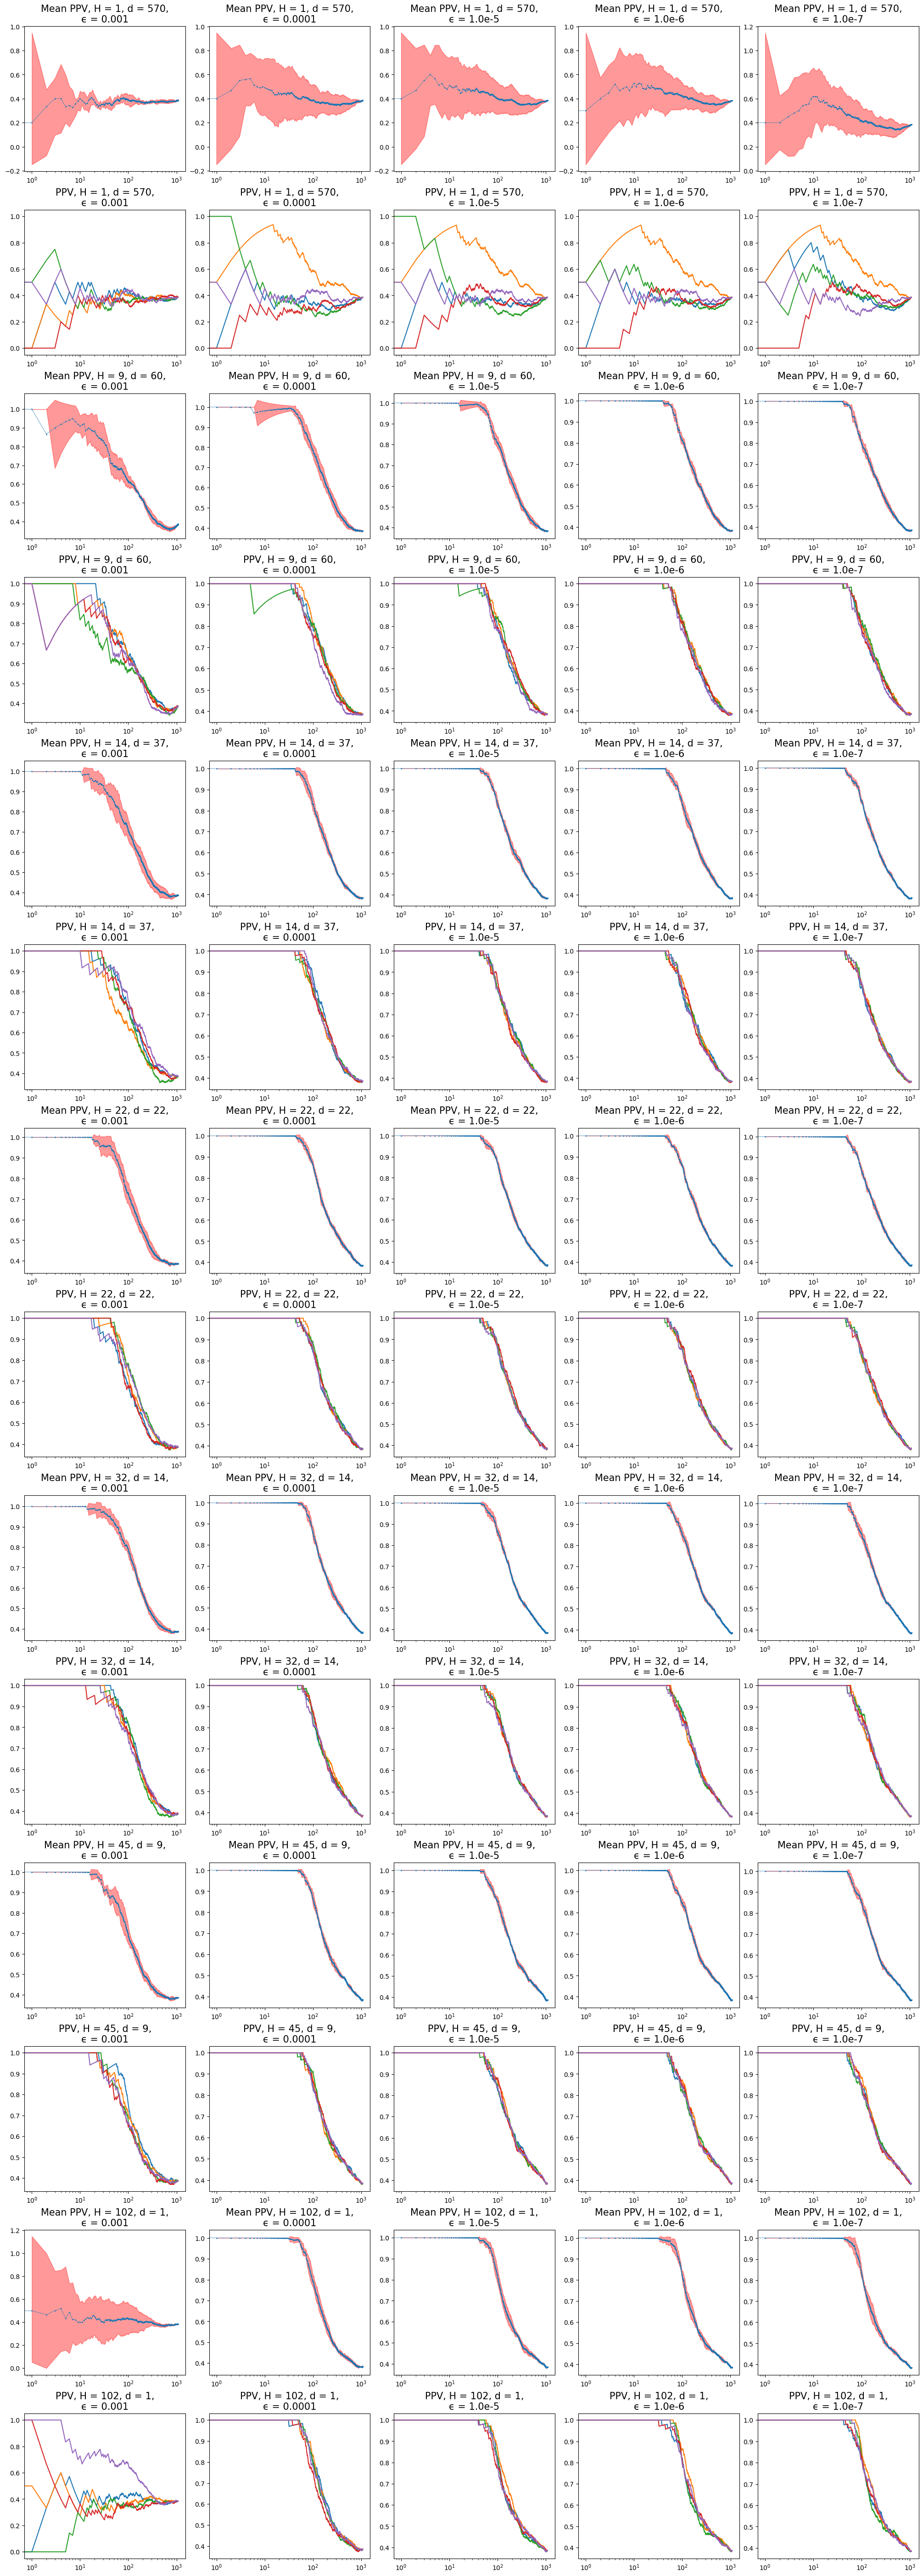

In [205]:
fig, axs = subplots(2*N,5, figsize=(4.0*5, 4.0*2*N), constrained_layout=true)
for i in 1:N
    for s in 1:5
        axs[2*i-1,s].semilogx(meanPPV[i][s], ".-", ms = 2, linewidth=0.5)
        axs[2*i-1,s].fill_between([1:length(meanPPV[i][s]);],meanPPV[i][s].-stdPPV[i][s],meanPPV[i][s].+stdPPV[i][s],alpha=0.4, color="r", label="variance")
        axs[2*i-1,s].set_title("Mean PPV, H = $(list[i][1]), d = $(list[i][2]),\nϵ = $(0.01/(10^s))",fontsize = 15)
        for m in 1:M
            axs[2*i,s].semilogx(PPV[i][m][s])
        end 
        axs[2*i,s].set_title("PPV, H = $(list[i][1]), d = $(list[i][2]),\nϵ = $(0.01/(10^s))", fontsize = 15)
    end
    
end

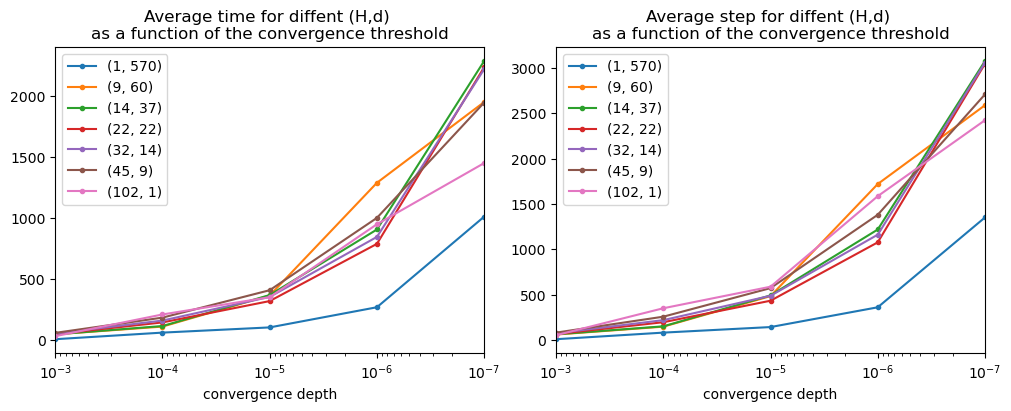

In [206]:
fig, axs = subplots(1,2, figsize=(10, 4), constrained_layout=true)

for i in 1:N
    axs[1].semilogx([1.0e-3, 1.0e-4, 1.0e-5, 1.0e-6, 1.0e-7],meantime[i][:],".-")
    axs[1].set_xlim(1.0e-3, 1.0e-7)
    axs[2].semilogx([1.0e-3, 1.0e-4, 1.0e-5, 1.0e-6, 1.0e-7],meanstep[i][:],".-")
    axs[2].set_xlim(1.0e-3, 1.0e-7)
end
axs[1].set_title("Average time for diffent (H,d) \nas a function of the convergence threshold")
axs[2].set_title("Average step for diffent (H,d) \nas a function of the convergence threshold")
axs[1].legend(list)
axs[2].legend(list)
axs[1].set_xlabel("convergence depth")
axs[2].set_xlabel("convergence depth");

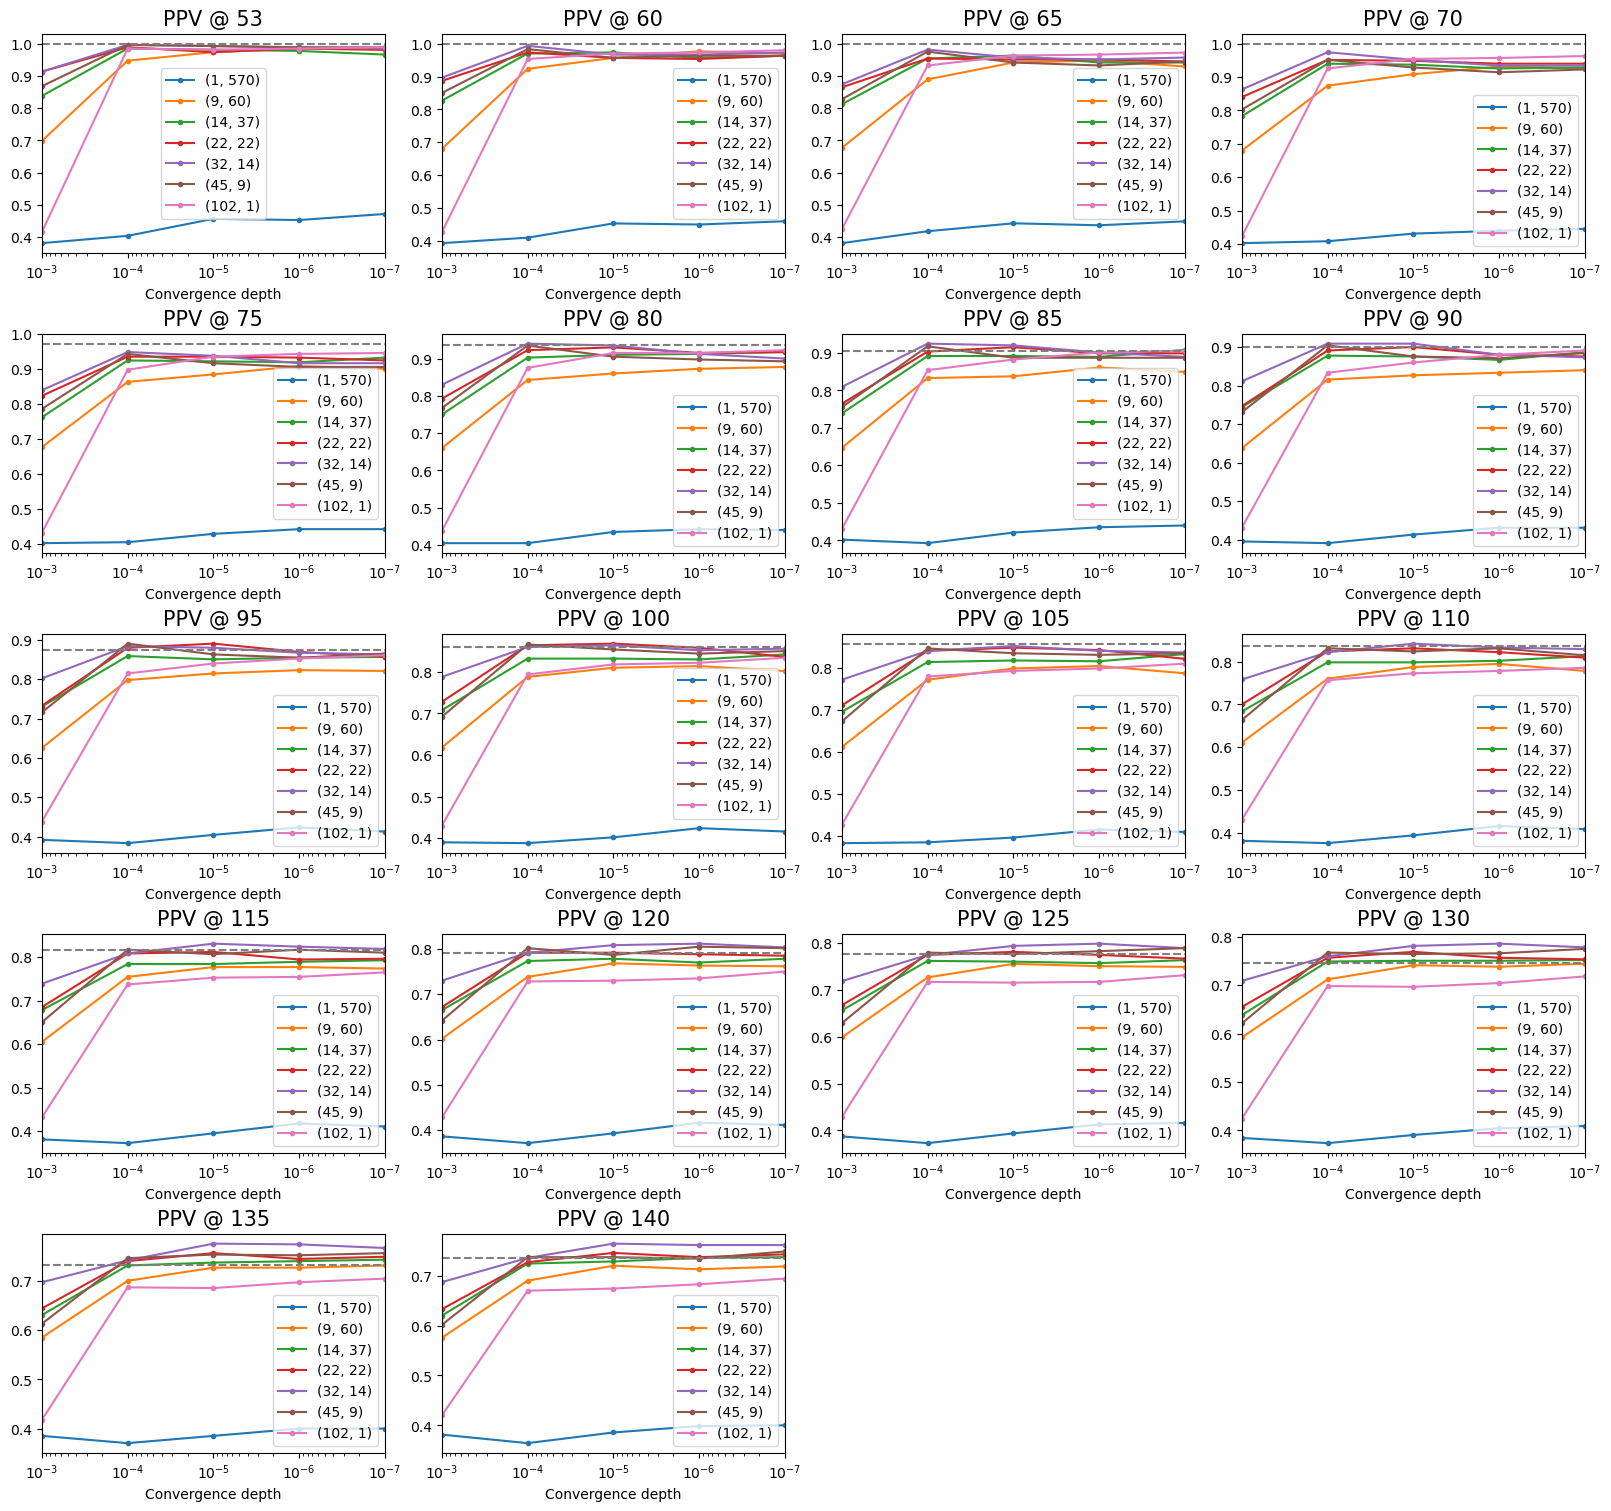

In [207]:
L = [53,60,65,70,75,80,85,90,95,100,105,110,115,120,125,130,135,140]



meanPPVN = zeros(length(L),N,5); 
for l in 1:length(L)
    for i in 1:7
        for s in 1:5
            meanPPVN[l,i,s] = meanPPV[i][s][L[l]]
        end
    end
end


n,m = [5,4]
fig, axs = subplots(n,m, figsize=(4.0*m, 3.0*n), constrained_layout=true)
for i in 1:n
    for j in 1:m
        if (i-1)*m + j <= length(L)
            for x in 1:N
                axs[i,j].semilogx([1.0e-3, 1.0e-4, 1.0e-5, 1.0e-6, 1.0e-7],meanPPVN[(i-1)*m + j,x,:],".-")
                axs[i,j].set_xlim(1.0e-3,1.0e-7)
            end
            axs[i,j].semilogx([1.0e-3,1.0e-7], fill(PPVplm[L[(i-1)*m + j]], 2),"--")
            axs[i,j].set_title("PPV @ $(L[(i-1)*m+j])", fontsize = 15)
            axs[i,j].legend(list)
            axs[i,j].set_xlabel("Convergence depth")
        else
            axs[i,j].set_visible(false)
        end
    end
end